<a href="https://colab.research.google.com/github/ChengyangHuang/Personalized_Regression/blob/main/Simulation_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial import KDTree
from scipy.spatial import distance_matrix

import torch

# np.random.seed(0)


def generate_data(N, P, K, sigma_eps):
    X = np.random.uniform(-1, 1, size=(N, P))
    U = np.random.uniform(0, 1, size=(N, K))
    a = (np.abs(U-0.5)>0.25) + 0.1*np.sin(3*np.pi*U)
    theta = np.concatenate((U, a), axis=1)

    w = np.random.normal(0, sigma_eps, size=(N, K))
    # Y = np.diag(np.dot(X, theta.T)).reshape((N, K)) + w
    Y = np.sum(np.multiply(X, theta), axis=1, keepdims=True)
    return X, Y, theta, U 


def plot_parameters(theta_gt, theta_est, PR=False):
    fig, ax = plt.subplots(1)
    idxs = np.linspace(0, theta_gt.shape[0]-1, 100, dtype=int)
    ax.scatter(theta_gt[idxs, 0], theta_gt[idxs, 1], label="True Parameters")
    if PR:
        ax.scatter(theta_est[idxs, 0], theta_est[idxs, 1], label="EST. Parameters")
    else:
        ax.scatter(theta_est[:, 0], theta_est[:, 1], label="EST. Parameters")
    ax.legend()
    return fig, ax


def print_metrics(dic):
    message = f"\n"
    for k, v in dic.items():
        message += f"{k}:\t{v}\n"
    print(message)


def evaluate_method(y_pred, y_test, theta_pred, theta_train, method_name):
    mse = mean_squared_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    dtheta_norm2 = np.linalg.norm(theta_pred-theta_train, ord=2) if method_name == "Personalized Regression" or method_name == "Linear Regression" else "TODO"
    performance_dict = {"method_name": method_name,
                        "MSE": mse,
                        "R2": R2,
                        "dtheta_n2": dtheta_norm2
                        }
    return performance_dict

In [44]:
class PR():
    def __init__(self, theta_pop, dataset, args):
        # Training Parameters
        self.sigma_theta = args.sigma_theta
        self.lambd = args.theta_regularizer
        self.gamma = args.distance_regularizer
        self.nu = args.phi_regularizer
        self.alpha = args.learning_rate
        self.c = args.lr_decay
        self.q = args.latent_dim
        self.log_steps = args.log_steps
        self.n_neighbors = args.n_neighbors
        self.show_logs = args.show_logs

        self.theta_pop = torch.from_numpy(theta_pop)
        self.p = self.theta_pop.shape[0]

        # Training Data
        X_train, y_train, theta_train, U_train = dataset
        self.X_train = torch.from_numpy(X_train)
        self.y_train = torch.from_numpy(y_train)
        self.U_train = torch.from_numpy(U_train)
        self.U_tree = KDTree(U_train) 
        self.U_distance_mat = torch.from_numpy(distance_matrix(U_train, U_train, p=2))
        self.theta_train = torch.from_numpy(theta_train)
        self.n = self.X_train.shape[0]
        self.k = self.U_train.shape[1]

        # Variable Initialization
        PI = np.random.multivariate_normal(theta_pop, self.sigma_theta*np.eye(self.p), size=self.n)
        self.PI = torch.from_numpy(PI)
        self.Z, self.Q = self.__init_ZnQ(PI)
        self.phi = torch.ones((self.k, ))

        # Loss Functions
        self.__sample_specific_loss = torch.nn.MSELoss(reduction='sum')
        self.__parameter_regularizer = torch.nn.L1Loss()
        self.__phi_regularizer = torch.nn.MSELoss()
        self.__distance_loss = torch.nn.MSELoss()


    def train(self, n_epoch=5):
        for epoch in range(n_epoch):
            Z = self.Z.clone().requires_grad_(True)
            Q = self.Q.clone().requires_grad_(True)
            phi = self.phi.clone().requires_grad_(True)
            PI = self.__update_PI(Z, Q) 

            y_pred = (self.X_train * PI).sum(dim=1, keepdim=True)

            # Calculate Loss
            l_loss = self.__sample_specific_loss(y_pred, self.y_train)
            # D_loss = self.__distance_matching_regularizer(Z, phi)
            D_loss = 0
            theta_loss = self.__parameter_regularizer(PI, torch.zeros_like(PI))
            phi_loss = self.__phi_regularizer(phi, torch.ones_like(phi))
            loss = l_loss + self.gamma * D_loss + self.lambd * theta_loss + self.nu * phi_loss
            
            # Update phi
            loss.backward()
            self.phi -= self.alpha * phi.grad

            # Update Z
            alpha_cust = self.alpha / torch.linalg.norm(self.PI-self.theta_pop, 
                                                        float('inf'), dim=1, keepdim=True)
            self.Z -= alpha_cust * Z.grad

            # Update Q
            self.Q -= self.alpha * Q.grad

            # Update alpha
            self.alpha *= self.c

            # Update theta, PI
            self.PI = self.__update_PI(self.Z, self.Q)

            if self.show_logs and epoch % self.log_steps == 0:
                message = f"Epoch {epoch+1} - Total loss: {loss}\tDistance loss:{D_loss}"
                print(message)
                plot_parameters(self.theta_train, self.PI)
                plt.show()
        

    def predict(self, X_test, U_test):
        X = torch.from_numpy(X_test)
        _, idx_sets = self.U_tree.query(U_test, k=self.n_neighbors)
        y_pred = []
        for i in range(X_test.shape[0]):
            idxs = idx_sets[i]
            theta = self.PI[idxs, :].mean(axis=0)
            y = torch.dot(X[i], theta).numpy()
            y_pred.append(y)  
        return y_pred


    def __init_ZnQ(self, PI):
        pca = PCA(n_components=self.q, whiten=False)
        Z = pca.fit_transform(PI)
        Q = pca.components_
        return torch.from_numpy(Z), torch.from_numpy(Q)
    

    def __update_PI(self, Z, Q):
        return torch.mm(Z, Q) + self.theta_pop
    

    def __distance_matching_regularizer(self, Z, phi):
        #TODO
        
        _Z = Z.detach().numpy()
        tree = KDTree(_Z)
        _, J_sets = tree.query(_Z, k=6)
        d_loss = 0
        for i in range(J_sets.shape[0]):
            J_set = J_sets[i][1:]
            dU = phi * self.U_distance_mat[i, J_set]
            dZ = torch.linalg.norm(Z[i] - Z[J_set, :], ord=2, dim=1)
            d_loss += self.__distance_loss(dZ, dU)
        return d_loss



method_name:	Linear Regression
MSE:	0.12966848589826696
R2:	0.5463098048691641
dtheta_n2:	12.382734074886518


method_name:	Gaussian Mixture
MSE:	2.03043483945248
R2:	-6.1041808819636625
dtheta_n2:	TODO


method_name:	Deep Neural Networks
MSE:	0.13099041418408341
R2:	0.5416845800291705
dtheta_n2:	TODO


method_name:	Personalized Regression
MSE:	0.0352694798923281
R2:	0.8765974854748628
dtheta_n2:	7.290175867794115



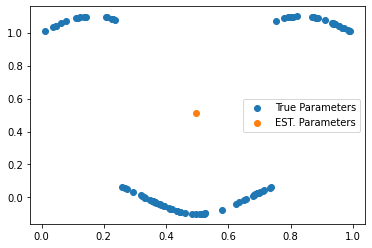

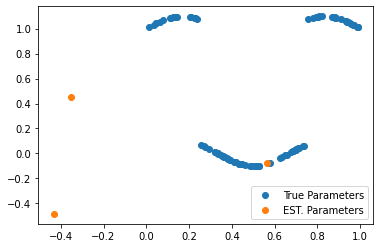

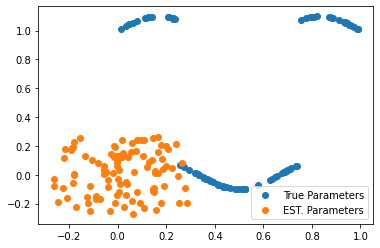

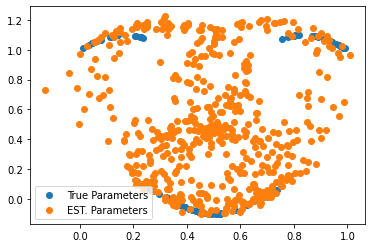

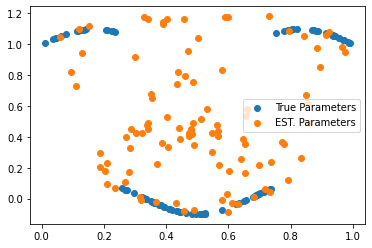

In [45]:
class Data_Arguments():
    N_train = 500
    N_test = 1000
    P = 2
    K = 1
    sigma_eps = 0.001


class PR_Arguments():
    sigma_theta = 0.001
    learning_rate = 4e-3
    lr_decay = 1 #1-1e-4
    latent_dim = 2
    n_epoch = 10000 #2000
    theta_regularizer = 0.01
    distance_regularizer = 0.01
    phi_regularizer = 0

    n_neighbors = 3
    log_steps = 100
    show_logs = False


def main():
    args = Data_Arguments()
    
    X_train, y_train, theta_train, U_train  = generate_data(args.N_train, args.P, args.K, args.sigma_eps)
    X_test, y_test, theta_test, U_test = generate_data(args.N_test, args.P, args.K, args.sigma_eps)

    result_list = []
    ## Linear Regression
    lr = LinearRegression().fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    theta_lr = np.array(lr.coef_)
    dict_lr = evaluate_method(y_pred_lr, y_test, theta_lr, theta_train, "Linear Regression")
    result_list.append((theta_lr, dict_lr))

    ## Other Baseline methods
    ## GMM
    gmm = GaussianMixture(3, max_iter=100).fit(X_train, y_train)
    # gmm = BayesianGaussianMixture(3).fit(X_train, y_train)
    y_pred_gmm = gmm.predict(X_test)
    theta_gmm = np.array(gmm.means_)
    dict_gmm = evaluate_method(y_pred_gmm, y_test, theta_gmm, theta_train, "Gaussian Mixture")
    result_list.append((theta_gmm, dict_gmm))

    ## DNN
    dnn = MLPRegressor(hidden_layer_sizes=(100,)).fit(X_train, y_train.squeeze())
    y_pred_dnn = dnn.predict(X_test)
    theta_dnn = np.array(dnn.coefs_[0].T)
    dict_dnn = evaluate_method(y_pred_dnn, y_test, theta_dnn, theta_train, "Deep Neural Networks")
    result_list.append((theta_dnn, dict_dnn))

    ## Personalized Regression
    pr_args = PR_Arguments()
    dataset_train = (X_train, y_train, theta_train, U_train)
    pr = PR(theta_lr.squeeze(), dataset_train, pr_args)
    pr.train(pr_args.n_epoch)
    y_pred_pr = pr.predict(X_test, U_test)
    theta_pr = pr.PI.numpy()
    dict_pr = evaluate_method(y_pred_pr, y_test, theta_pr, theta_train, "Personalized Regression")
    result_list.append((theta_pr, dict_pr))

    for t, d in result_list:
        # plot_parameters(theta_train, t, d["method_name"]=="Personalized Regression")
        plot_parameters(theta_train, t, False)
        print_metrics(d)
    plot_parameters(theta_train, t, True)

if __name__ == "__main__":
    main()